In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
customers = pd.read_csv('/content/drive/MyDrive/Customers.csv')
transactions = pd.read_csv('/content/drive/MyDrive/Transactions.csv')
products = pd.read_csv('/content/drive/MyDrive/Products.csv')

In [4]:
merged_data = transactions.merge(customers, on='CustomerID')
merged_data = merged_data.merge(products, on='ProductID')

In [7]:
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'TransactionID': 'count',  # Transaction frequency
    'Price_x': 'mean',  # Average transaction value (adjusted to Price_x)
    'Category': 'nunique',  # Unique product categories purchased
}).reset_index()

In [8]:
category_data = merged_data.groupby('CustomerID')['Category'].agg(
    lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan  # Most frequently purchased category
).reset_index()
category_data.columns = ['CustomerID', 'FavoriteCategory']

In [9]:
customer_features = customer_features.merge(category_data, on='CustomerID')

In [11]:
customer_features = customer_features.merge(customers[['CustomerID', 'Region']], on='CustomerID')

In [14]:

print(customers.columns)

print(customer_features.columns)


Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate'], dtype='object')
Index(['CustomerID', 'TotalValue', 'TransactionID', 'Price_x', 'Category',
       'FavoriteCategory', 'Region_x', 'Region_y'],
      dtype='object')


In [15]:
customer_features = customer_features.drop(columns=['Region_x'])
customer_features = customer_features.rename(columns={'Region_y': 'Region'})

In [16]:
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)


In [17]:
print(customer_features.columns)

Index(['CustomerID', 'TotalValue', 'TransactionID', 'Price_x', 'Category',
       'FavoriteCategory', 'Region_Europe', 'Region_North America',
       'Region_South America'],
      dtype='object')


In [26]:
numeric_features = customer_features.select_dtypes(include=['number'])

In [27]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features)

In [28]:
cluster_results = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, cluster_labels)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)

    cluster_results.append({
        'n_clusters': n_clusters,
        'DB Index': db_index,
        'Silhouette Score': silhouette_avg,
        'Cluster Centers': kmeans.cluster_centers_,
        'Labels': cluster_labels
    })


In [29]:
best_result = min(cluster_results, key=lambda x: x['DB Index'])

In [30]:
customer_features['Cluster'] = best_result['Labels']


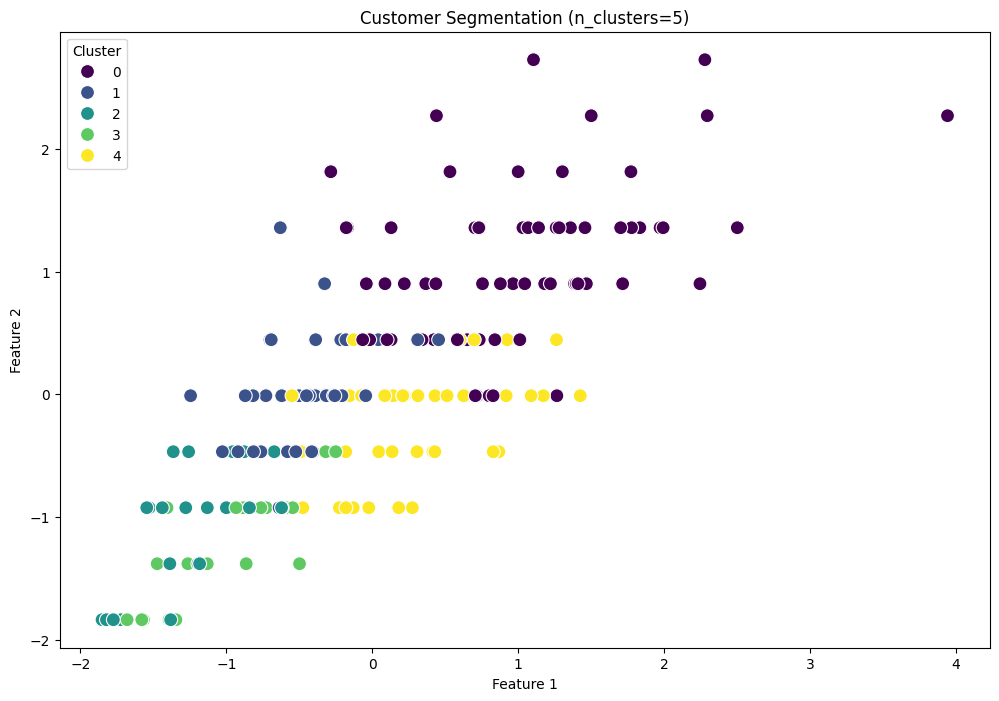

In [31]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=scaled_features[:, 0], y=scaled_features[:, 1],
    hue=customer_features['Cluster'], palette='viridis', s=100
)
plt.title(f"Customer Segmentation (n_clusters={best_result['n_clusters']})")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster')
plt.show()

In [33]:
print(f"Best Number of Clusters: {best_result['n_clusters']}")
print(f"DB Index: {best_result['DB Index']:.4f}")
print(f"Silhouette Score: {best_result['Silhouette Score']:.4f}")

Best Number of Clusters: 5
DB Index: 1.0852
Silhouette Score: 0.2653
